In [27]:
import random
import time
from functools import reduce
from operator import mul

# Prime number larger than any possible secret for the finite field
PRIME = 208351617316091241234326746312124448251235562226470491514186331217050270460481

# Program 1: Shamir's Secret Sharing Scheme
def generate_coefficients(secret, k):
    coeffs = [secret]
    for _ in range(k - 1):
        coeffs.append(random.SystemRandom().randint(0, PRIME - 1))
    return coeffs

def polynomial(x, coeffs):
    return sum([coeffs[i] * (x ** i) for i in range(len(coeffs))]) % PRIME

def generate_shares(secret, n, k):
    coeffs = generate_coefficients(secret, k)
    shares = [(i, polynomial(i, coeffs)) for i in range(1, n + 1)]
    return shares

def reconstruct_secret(shares):
    def lagrange_interpolate(x, x_s, y_s):
        def product(nums):
            return reduce(mul, nums)

        k = len(x_s)
        result = 0
        for i in range(k):
            xi, yi = x_s[i], y_s[i]
            li = product([(x - xj) * pow(xi - xj, -1, PRIME) % PRIME for j, xj in enumerate(x_s) if j != i])
            result += yi * li
        return result % PRIME

    x_s, y_s = zip(*shares)
    return lagrange_interpolate(0, x_s, y_s)

# Program 2: XOR-based Secret Sharing
def encode(secret):
    # Convert the integer secret into a binary string
    M = bin(secret)[2:]  # Remove the '0b' prefix
    
    # Make the length even by appending '0' if necessary
    if len(M) % 2 != 0:
        M += '0'
    
    half_len = len(M) // 2
    
    # Split M into two equal parts
    M1 = M[:half_len]
    M2 = M[half_len:]
    
    # Generate two random binary sequences R1 and R2
    R1 = [random.randint(0, 1) for _ in range(half_len)]
    R2 = [random.randint(0, 1) for _ in range(half_len)]
    
    # Encoding
    E1 = R1 + [int(M2[i]) ^ R2[i] for i in range(half_len)]
    E2 = [int(M1[i]) ^ R1[i] for i in range(half_len)] + R2
    E3 = [int(M1[i]) ^ R2[i] for i in range(half_len)] + [int(M2[i]) ^ R1[i] for i in range(half_len)]
    
    return E1, E2, E3

def decode(part1, part2):
    half_len = len(part1) // 2
    
    if part1 == E1 and part2 == E2:
        # Decode using E1 and E2
        R1 = part1[:half_len]
        R2 = part2[half_len:]
        M1 = [part2[i] ^ R1[i] for i in range(half_len)]
        M2 = [part1[half_len + i] ^ R2[i] for i in range(half_len)]
    elif part1 == E1 and part2 == E3:
        # Decode using E1 and E3
        R1 = part1[:half_len]
        M2 = [part2[half_len + i] ^ R1[i] for i in range(half_len)]
        R2 = [part1[half_len + i] ^ M2[i] for i in range(half_len)]
        M1 = [part2[i] ^ R2[i] for i in range(half_len)]
    elif part1 == E2 and part2 == E3:
        # Decode using E2 and E3
        R2 = part1[half_len:]
        M1 = [part2[i] ^ R2[i] for i in range(half_len)]
        R1 = [part1[i] ^ M1[i] for i in range(half_len)]
        M2 = [part2[half_len + i] ^ R1[i] for i in range(half_len)]
    
    M = M1 + M2
    return int(''.join(map(str, M)), 2)  # Convert binary list back to integer

if __name__ == "__main__":
    
    # Use a small secret
    secret = 12345

    # Program 1: Shamir's Secret Sharing
    n = 3
    k = 2
    
    # Encoding (Generating Shares)
    start_time = time.time()
    shares = generate_shares(secret, n, k)
    encoder_runtime_shamir = time.time() - start_time
    
    # Decoding (Reconstructing Secret)
    start_time = time.time()
    recovered_secret_shamir = reconstruct_secret(shares[:k])
    decoder_runtime_shamir = time.time() - start_time

    # Program 2: XOR-based Secret Sharing
    # Encoding (Generating Shares)
    start_time = time.time()
    E1, E2, E3 = encode(secret)
    encoder_runtime_xor = time.time() - start_time
    

    # Print Results
    print("Shamir's Secret Sharing:")
    print(f"Encoder Runtime: {encoder_runtime_shamir:.6f} seconds")
    print(f"Decoder Runtime: {decoder_runtime_shamir:.6f} seconds")
    print(f"Recovered Secret: {recovered_secret_shamir}")
    print()
    
    # Measure runtime for generating shares (encoder)
    start_time = time.time()
    E1, E2, E3 = encode(secret)
    encoder_runtime = time.time() - start_time
    print(f"Shares: E1={E1}, E2={E2}, E3={E3}")
    print(f"Encoder Runtime: {encoder_runtime:.6f} seconds")

    # Measure runtime for reconstructing the secret (decoder) using E1 and E2
    start_time = time.time()
    recovered_secret = decode(E1, E2)
    decoder_runtime = time.time() - start_time
    print(f"Recovered Secret (E1 and E2): {recovered_secret}")
    print(f"Decoder Runtime: {decoder_runtime:.6f} seconds")

    # Measure runtime for reconstructing the secret (decoder) using E1 and E3
    start_time = time.time()
    recovered_secret = decode(E1, E3)
    decoder_runtime = time.time() - start_time
    print(f"Recovered Secret (E1 and E3): {recovered_secret}")
    print(f"Decoder Runtime: {decoder_runtime:.6f} seconds")

    # Measure runtime for reconstructing the secret (decoder) using E2 and E3
    start_time = time.time()
    recovered_secret = decode(E2, E3)
    decoder_runtime = time.time() - start_time
    print(f"Recovered Secret (E2 and E3): {recovered_secret}")
    print(f"Decoder Runtime: {decoder_runtime:.6f} seconds")




Shamir's Secret Sharing:
Encoder Runtime: 0.000259 seconds
Decoder Runtime: 0.000017 seconds
Recovered Secret: 12345

Shares: E1=[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1], E2=[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0], E3=[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
Encoder Runtime: 0.000030 seconds
Recovered Secret (E1 and E2): 12345
Decoder Runtime: 0.000012 seconds
Recovered Secret (E1 and E3): 12345
Decoder Runtime: 0.000006 seconds
Recovered Secret (E2 and E3): 12345
Decoder Runtime: 0.000005 seconds


Shamir's Secret Sharing:
Encoder Runtime: 0.000027 seconds
Decoder Runtime: 0.000011 seconds
Recovered Secret: 12345

XOR-based Secret Sharing:
Encoder Runtime: 0.000018 seconds
Decoder Runtime (E1, E2): 0.000020 seconds
Decoder Runtime (E1, E3): 0.000004 seconds
Decoder Runtime (E2, E3): 0.000004 seconds


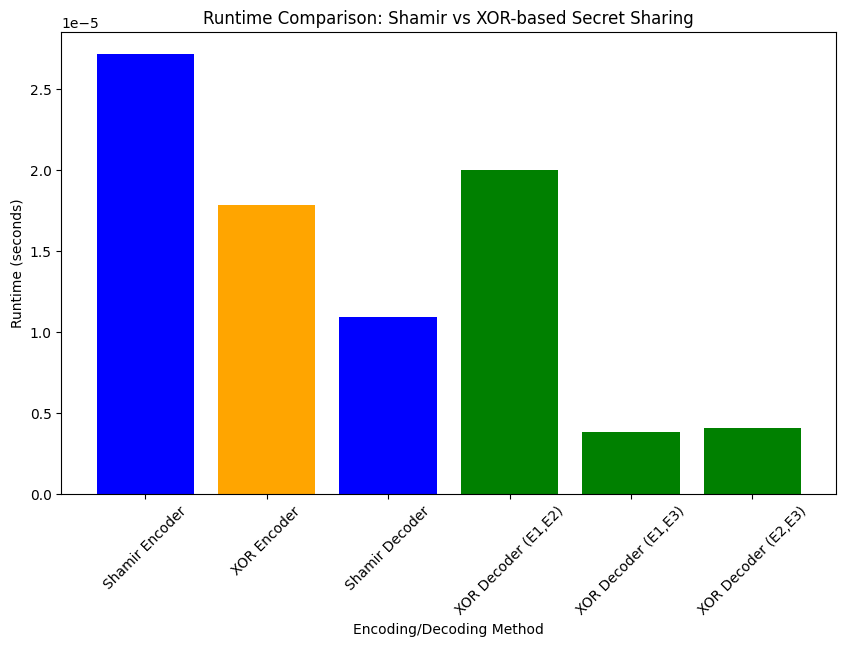

In [28]:
import random
import time
from functools import reduce
from operator import mul
import matplotlib.pyplot as plt

# Prime number larger than any possible secret for the finite field
PRIME = 208351617316091241234326746312124448251235562226470491514186331217050270460481

# Program 1: Shamir's Secret Sharing Scheme
def generate_coefficients(secret, k):
    coeffs = [secret]
    for _ in range(k - 1):
        coeffs.append(random.SystemRandom().randint(0, PRIME - 1))
    return coeffs

def polynomial(x, coeffs):
    return sum([coeffs[i] * (x ** i) for i in range(len(coeffs))]) % PRIME

def generate_shares(secret, n, k):
    coeffs = generate_coefficients(secret, k)
    shares = [(i, polynomial(i, coeffs)) for i in range(1, n + 1)]
    return shares

def reconstruct_secret(shares):
    def lagrange_interpolate(x, x_s, y_s):
        def product(nums):
            return reduce(mul, nums)

        k = len(x_s)
        result = 0
        for i in range(k):
            xi, yi = x_s[i], y_s[i]
            li = product([(x - xj) * pow(xi - xj, -1, PRIME) % PRIME for j, xj in enumerate(x_s) if j != i])
            result += yi * li
        return result % PRIME

    x_s, y_s = zip(*shares)
    return lagrange_interpolate(0, x_s, y_s)

# Program 2: XOR-based Secret Sharing
def encode(secret):
    # Convert the integer secret into a binary string
    M = bin(secret)[2:]  # Remove the '0b' prefix
    
    # Make the length even by appending '0' if necessary
    if len(M) % 2 != 0:
        M += '0'
    
    half_len = len(M) // 2
    
    # Split M into two equal parts
    M1 = M[:half_len]
    M2 = M[half_len:]
    
    # Generate two random binary sequences R1 and R2
    R1 = [random.randint(0, 1) for _ in range(half_len)]
    R2 = [random.randint(0, 1) for _ in range(half_len)]
    
    # Encoding
    E1 = R1 + [int(M2[i]) ^ R2[i] for i in range(half_len)]
    E2 = [int(M1[i]) ^ R1[i] for i in range(half_len)] + R2
    E3 = [int(M1[i]) ^ R2[i] for i in range(half_len)] + [int(M2[i]) ^ R1[i] for i in range(half_len)]
    
    return E1, E2, E3

def decode(part1, part2):
    half_len = len(part1) // 2
    
    if part1 == E1 and part2 == E2:
        # Decode using E1 and E2
        R1 = part1[:half_len]
        R2 = part2[half_len:]
        M1 = [part2[i] ^ R1[i] for i in range(half_len)]
        M2 = [part1[half_len + i] ^ R2[i] for i in range(half_len)]
    elif part1 == E1 and part2 == E3:
        # Decode using E1 and E3
        R1 = part1[:half_len]
        M2 = [part2[half_len + i] ^ R1[i] for i in range(half_len)]
        R2 = [part1[half_len + i] ^ M2[i] for i in range(half_len)]
        M1 = [part2[i] ^ R2[i] for i in range(half_len)]
    elif part1 == E2 and part2 == E3:
        # Decode using E2 and E3
        R2 = part1[half_len:]
        M1 = [part2[i] ^ R2[i] for i in range(half_len)]
        R1 = [part1[i] ^ M1[i] for i in range(half_len)]
        M2 = [part2[half_len + i] ^ R1[i] for i in range(half_len)]
    
    M = M1 + M2
    return int(''.join(map(str, M)), 2)  # Convert binary list back to integer

if __name__ == "__main__":
    
    # Use a small secret
    secret = 12345

    # Program 1: Shamir's Secret Sharing
    n = 3
    k = 2
    
    # Encoding (Generating Shares)
    start_time = time.time()
    shares = generate_shares(secret, n, k)
    encoder_runtime_shamir = time.time() - start_time
    
    # Decoding (Reconstructing Secret)
    start_time = time.time()
    recovered_secret_shamir = reconstruct_secret(shares[:k])
    decoder_runtime_shamir = time.time() - start_time

    # Program 2: XOR-based Secret Sharing
    # Encoding (Generating Shares)
    start_time = time.time()
    E1, E2, E3 = encode(secret)
    encoder_runtime_xor = time.time() - start_time

    # Measure runtime for reconstructing the secret (decoder) using E1 and E2
    start_time = time.time()
    recovered_secret_E1_E2 = decode(E1, E2)
    decoder_runtime_E1_E2 = time.time() - start_time

    # Measure runtime for reconstructing the secret (decoder) using E1 and E3
    start_time = time.time()
    recovered_secret_E1_E3 = decode(E1, E3)
    decoder_runtime_E1_E3 = time.time() - start_time

    # Measure runtime for reconstructing the secret (decoder) using E2 and E3
    start_time = time.time()
    recovered_secret_E2_E3 = decode(E2, E3)
    decoder_runtime_E2_E3 = time.time() - start_time

    # Print Results
    print("Shamir's Secret Sharing:")
    print(f"Encoder Runtime: {encoder_runtime_shamir:.6f} seconds")
    print(f"Decoder Runtime: {decoder_runtime_shamir:.6f} seconds")
    print(f"Recovered Secret: {recovered_secret_shamir}")
    print()
    
    print("XOR-based Secret Sharing:")
    print(f"Encoder Runtime: {encoder_runtime_xor:.6f} seconds")
    print(f"Decoder Runtime (E1, E2): {decoder_runtime_E1_E2:.6f} seconds")
    print(f"Decoder Runtime (E1, E3): {decoder_runtime_E1_E3:.6f} seconds")
    print(f"Decoder Runtime (E2, E3): {decoder_runtime_E2_E3:.6f} seconds")

    # Plotting the results
    labels = ['Shamir Encoder', 'XOR Encoder', 'Shamir Decoder', 'XOR Decoder (E1,E2)', 'XOR Decoder (E1,E3)', 'XOR Decoder (E2,E3)']
    runtimes = [encoder_runtime_shamir, encoder_runtime_xor, decoder_runtime_shamir, decoder_runtime_E1_E2, decoder_runtime_E1_E3, decoder_runtime_E2_E3]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, runtimes, color=['blue', 'orange', 'blue', 'green', 'green', 'green'])
    plt.xlabel('Encoding/Decoding Method')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime Comparison: Shamir vs XOR-based Secret Sharing')
    plt.xticks(rotation=45)
    plt.show()


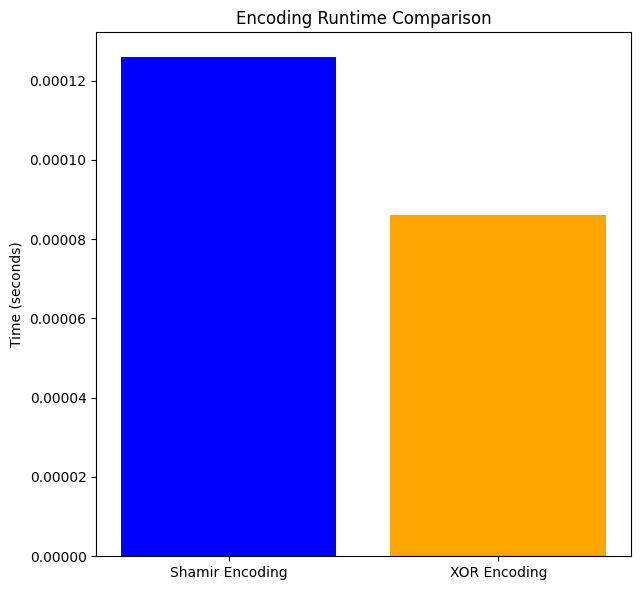

In [33]:
import random
import time
import matplotlib.pyplot as plt
from functools import reduce
from operator import mul

# Prime number larger than any possible secret for the finite field
PRIME = 208351617316091241234326746312124448251235562226470491514186331217050270460481

# Program 1: Shamir's Secret Sharing Scheme
def generate_coefficients(secret, k):
    coeffs = [secret]
    for _ in range(k - 1):
        coeffs.append(random.SystemRandom().randint(0, PRIME - 1))
    return coeffs

def polynomial(x, coeffs):
    return sum([coeffs[i] * (x ** i) for i in range(len(coeffs))]) % PRIME

def generate_shares(secret, n, k):
    coeffs = generate_coefficients(secret, k)
    shares = [(i, polynomial(i, coeffs)) for i in range(1, n + 1)]
    return shares

def reconstruct_secret(shares):
    def lagrange_interpolate(x, x_s, y_s):
        def product(nums):
            return reduce(mul, nums)

        k = len(x_s)
        result = 0
        for i in range(k):
            xi, yi = x_s[i], y_s[i]
            li = product([(x - xj) * pow(xi - xj, -1, PRIME) % PRIME for j, xj in enumerate(x_s) if j != i])
            result += yi * li
        return result % PRIME

    x_s, y_s = zip(*shares)
    return lagrange_interpolate(0, x_s, y_s)

# Program 2: XOR-based Secret Sharing
def encode(secret):
    # Convert the integer secret into a binary string
    M = bin(secret)[2:]  # Remove the '0b' prefix
    
    # Make the length even by appending '0' if necessary
    if len(M) % 2 != 0:
        M += '0'
    
    half_len = len(M) // 2
    
    # Split M into two equal parts
    M1 = M[:half_len]
    M2 = M[half_len:]
    
    # Generate two random binary sequences R1 and R2
    R1 = [random.randint(0, 1) for _ in range(half_len)]
    R2 = [random.randint(0, 1) for _ in range(half_len)]
    
    # Encoding
    E1 = R1 + [int(M2[i]) ^ R2[i] for i in range(half_len)]
    E2 = [int(M1[i]) ^ R1[i] for i in range(half_len)] + R2
    E3 = [int(M1[i]) ^ R2[i] for i in range(half_len)] + [int(M2[i]) ^ R1[i] for i in range(half_len)]
    
    return E1, E2, E3

def decode(part1, part2, E1, E2, E3):
    half_len = len(part1) // 2
    
    if part1 == E1 and part2 == E2:
        # Decode using E1 and E2
        R1 = part1[:half_len]
        R2 = part2[half_len:]
        M1 = [part2[i] ^ R1[i] for i in range(half_len)]
        M2 = [part1[half_len + i] ^ R2[i] for i in range(half_len)]
    elif part1 == E1 and part2 == E3:
        # Decode using E1 and E3
        R1 = part1[:half_len]
        M2 = [part2[half_len + i] ^ R1[i] for i in range(half_len)]
        R2 = [part1[half_len + i] ^ M2[i] for i in range(half_len)]
        M1 = [part2[i] ^ R2[i] for i in range(half_len)]
    elif part1 == E2 and part2 == E3:
        # Decode using E2 and E3
        R2 = part1[half_len:]
        M1 = [part2[i] ^ R2[i] for i in range(half_len)]
        R1 = [part1[i] ^ M1[i] for i in range(half_len)]
        M2 = [part2[half_len + i] ^ R1[i] for i in range(half_len)]
    
    M = M1 + M2
    return int(''.join(map(str, M)), 2)  # Convert binary list back to integer

# Benchmark the two methods
secret = 12345

# Program 1: Shamir's Secret Sharing
n = 3
k = 2

# Measure runtime for Shamir's Secret Sharing (Encoding)
start_time = time.time()
shares = generate_shares(secret, n, k)
encoder_runtime_shamir = time.time() - start_time

# Measure runtime for Shamir's Secret Sharing (Decoding)
start_time = time.time()
recovered_secret_shamir = reconstruct_secret(shares[:k])
decoder_runtime_shamir = time.time() - start_time

# Program 2: XOR-based Secret Sharing
# Measure runtime for XOR-based Secret Sharing (Encoding)
start_time = time.time()
E1, E2, E3 = encode(secret)
encoder_runtime_xor = time.time() - start_time

# Measure runtime for XOR-based Secret Sharing (Decoding)
start_time = time.time()
recovered_secret_E1_E2 = decode(E1, E2, E1, E2, E3)
decoder_runtime_E1_E2 = time.time() - start_time

start_time = time.time()
recovered_secret_E1_E3 = decode(E1, E3, E1, E2, E3)
decoder_runtime_E1_E3 = time.time() - start_time

start_time = time.time()
recovered_secret_E2_E3 = decode(E2, E3, E1, E2, E3)
decoder_runtime_E2_E3 = time.time() - start_time

# Plotting the results
plt.figure(figsize=(12, 6))

# Encoding Runtime Comparison
plt.subplot(1, 2, 1)
plt.bar(['Shamir Encoding', 'XOR Encoding'], [encoder_runtime_shamir, encoder_runtime_xor], color=['blue', 'orange'])
plt.title('Encoding Runtime Comparison')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()


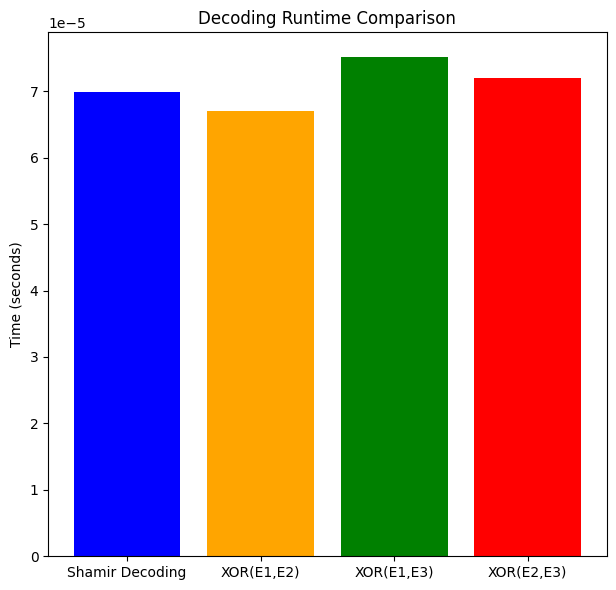

In [34]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Decoding Runtime Comparison
plt.subplot(1, 2, 2)
plt.bar(['Shamir Decoding', 'XOR(E1,E2)', 'XOR(E1,E3)', 'XOR(E2,E3)'],
        [decoder_runtime_shamir, decoder_runtime_E1_E2, decoder_runtime_E1_E3, decoder_runtime_E2_E3],
        color=['blue', 'orange', 'green', 'red'])
plt.title('Decoding Runtime Comparison')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

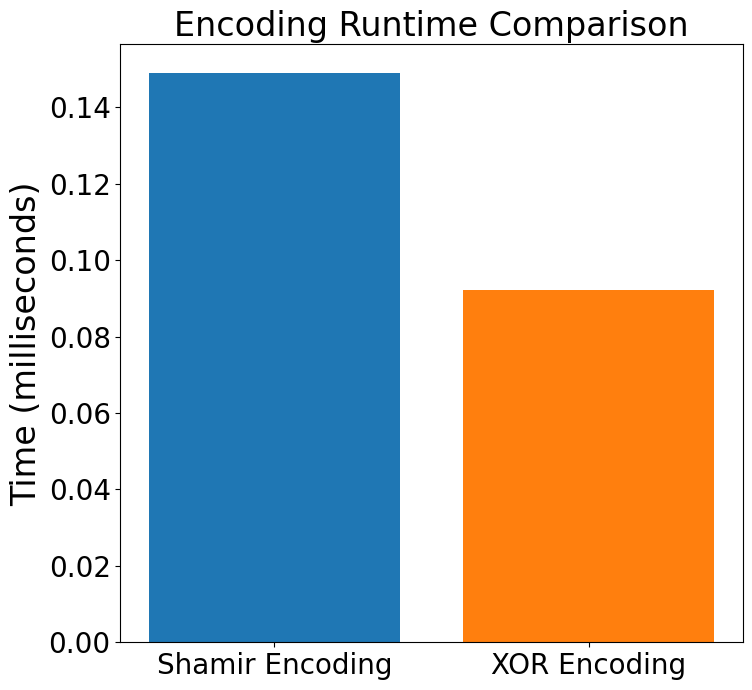

In [37]:
import random
import time
import matplotlib.pyplot as plt
from functools import reduce
from operator import mul

# Prime number larger than any possible secret for the finite field
PRIME = 208351617316091241234326746312124448251235562226470491514186331217050270460481

# Program 1: Shamir's Secret Sharing Scheme
def generate_coefficients(secret, k):
    coeffs = [secret]
    for _ in range(k - 1):
        coeffs.append(random.SystemRandom().randint(0, PRIME - 1))
    return coeffs

def polynomial(x, coeffs):
    return sum([coeffs[i] * (x ** i) for i in range(len(coeffs))]) % PRIME

def generate_shares(secret, n, k):
    coeffs = generate_coefficients(secret, k)
    shares = [(i, polynomial(i, coeffs)) for i in range(1, n + 1)]
    return shares

def reconstruct_secret(shares):
    def lagrange_interpolate(x, x_s, y_s):
        def product(nums):
            return reduce(mul, nums)

        k = len(x_s)
        result = 0
        for i in range(k):
            xi, yi = x_s[i], y_s[i]
            li = product([(x - xj) * pow(xi - xj, -1, PRIME) % PRIME for j, xj in enumerate(x_s) if j != i])
            result += yi * li
        return result % PRIME

    x_s, y_s = zip(*shares)
    return lagrange_interpolate(0, x_s, y_s)

# Program 2: XOR-based Secret Sharing
def encode(secret):
    M = bin(secret)[2:]
    if len(M) % 2 != 0:
        M += '0'
    half_len = len(M) // 2
    M1 = M[:half_len]
    M2 = M[half_len:]
    R1 = [random.randint(0, 1) for _ in range(half_len)]
    R2 = [random.randint(0, 1) for _ in range(half_len)]
    E1 = R1 + [int(M2[i]) ^ R2[i] for i in range(half_len)]
    E2 = [int(M1[i]) ^ R1[i] for i in range(half_len)] + R2
    E3 = [int(M1[i]) ^ R2[i] for i in range(half_len)] + [int(M2[i]) ^ R1[i] for i in range(half_len)]
    return E1, E2, E3

def decode(part1, part2, E1, E2, E3):
    half_len = len(part1) // 2
    if part1 == E1 and part2 == E2:
        R1 = part1[:half_len]
        R2 = part2[half_len:]
        M1 = [part2[i] ^ R1[i] for i in range(half_len)]
        M2 = [part1[half_len + i] ^ R2[i] for i in range(half_len)]
    elif part1 == E1 and part2 == E3:
        R1 = part1[:half_len]
        M2 = [part2[half_len + i] ^ R1[i] for i in range(half_len)]
        R2 = [part1[half_len + i] ^ M2[i] for i in range(half_len)]
        M1 = [part2[i] ^ R2[i] for i in range(half_len)]
    elif part1 == E2 and part2 == E3:
        R2 = part1[half_len:]
        M1 = [part2[i] ^ R2[i] for i in range(half_len)]
        R1 = [part1[i] ^ M1[i] for i in range(half_len)]
        M2 = [part2[half_len + i] ^ R1[i] for i in range(half_len)]
    M = M1 + M2
    return int(''.join(map(str, M)), 2)

# Benchmark the two methods
secret = 12345
n = 3
k = 2

start_time = time.time()
shares = generate_shares(secret, n, k)
encoder_runtime_shamir = (time.time() - start_time) * 1000  # Convert to milliseconds

start_time = time.time()
recovered_secret_shamir = reconstruct_secret(shares[:k])
decoder_runtime_shamir = (time.time() - start_time) * 1000  # Convert to milliseconds

start_time = time.time()
E1, E2, E3 = encode(secret)
encoder_runtime_xor = (time.time() - start_time) * 1000  # Convert to milliseconds

start_time = time.time()
recovered_secret_E1_E2 = decode(E1, E2, E1, E2, E3)
decoder_runtime_E1_E2 = (time.time() - start_time) * 1000  # Convert to milliseconds

start_time = time.time()
recovered_secret_E1_E3 = decode(E1, E3, E1, E2, E3)
decoder_runtime_E1_E3 = (time.time() - start_time) * 1000  # Convert to milliseconds

start_time = time.time()
recovered_secret_E2_E3 = decode(E2, E3, E1, E2, E3)
decoder_runtime_E2_E3 = (time.time() - start_time) * 1000  # Convert to milliseconds

# Plotting the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.bar(['Shamir Encoding', 'XOR Encoding'], [encoder_runtime_shamir, encoder_runtime_xor], color=['#1f77b4', '#ff7f0e'])
plt.title('Encoding Runtime Comparison', fontsize=24)
plt.ylabel('Time (milliseconds)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()


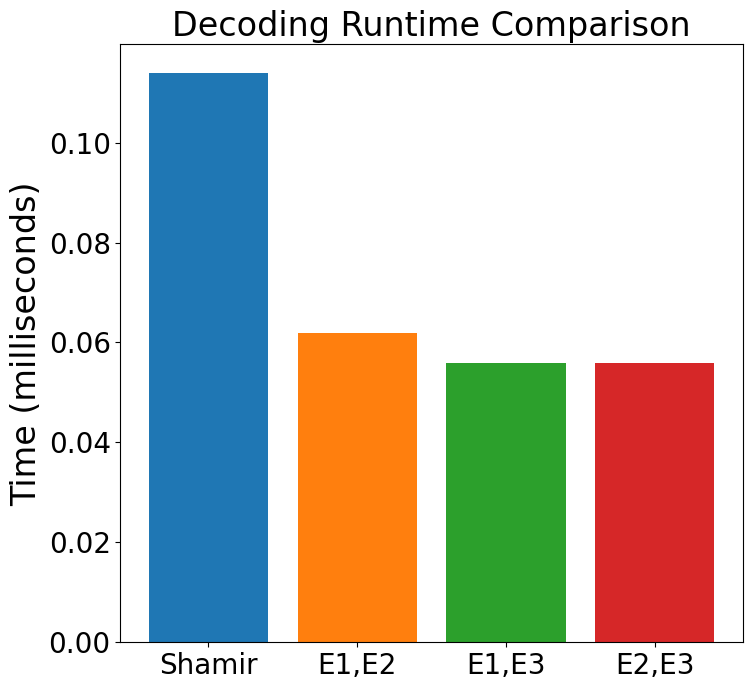

In [38]:
# Plotting the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 2)
plt.bar(['Shamir', 'E1,E2', 'E1,E3', 'E2,E3'],
        [decoder_runtime_shamir, decoder_runtime_E1_E2, decoder_runtime_E1_E3, decoder_runtime_E2_E3],
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Decoding Runtime Comparison', fontsize=24)
plt.ylabel('Time (milliseconds)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()
